In [11]:
# C0797202 JAY PANCHAL 

In [12]:
%pip install memory_profiler
%load_ext memory_profiler
%pip install gym
%pip install JSAnimation
%pip install matplotlib
%pip install -U gym >= 0.21.0
%pip install -U gym[atari,accept-rom-license]

%%file training.py

%%python -m memory_profiler


Note: you may need to restart the kernel to use updated packages.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
UsageError: Line magic function `%%file` not found.


In [13]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
from matplotlib import animation

from memory_profiler import profile

from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

## Initiating Ping Pong 

In [14]:
# Importing gym library and creating environment
import gym
env = gym.make('Pong-v0')

In [15]:
env.action_space
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [16]:
# Run a demo of the environment
observation = env.reset()
cumulated_reward = 0

frames = []
for t in range(1000):
#     print(observation)
    frames.append(env.render(mode = 'rgb_array'))
    # very stupid agent, just makes a random action within the allowd action space
    action = env.action_space.sample()
#     print("Action: {}".format(t+1))    
    observation, reward, done, info = env.step(action)
#     print(reward)
    cumulated_reward += reward
    if done:
        print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
        break
print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))

env.close()

Episode finished without success, accumulated reward = -20.0


In [17]:
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

# Logic behind the game

In [18]:


# Init the model

# number of neurons
H = 600 

# input dimensionality: 80x80 grid
D = 80 * 80 

model = {}
def update_neurons(neurons = 600):
    H = neurons
    
    # "Xavier" initialization
    
    model['W1'] = np.random.randn(H,D) / np.sqrt(D)
    model['W2'] = np.random.randn(H) / np.sqrt(H)

update_neurons(H)

# import pickle
#  model = pickle.load(open('model.pkl', 'rb'))

In [19]:

# hyperparameters
batch_size = 10 # every how many episodes to do a param update?

# learning_rate = 1e-4
learning_rate = 1e-4
 
# discount factor for reward
gamma = 0.99 

# decay factor for RMSProp leaky sum of grad^2
decay_rate = 0.99 
  
# update buffers that add up gradients over a batch
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } 

# rmsprop memory
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } 

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r, dtype=np.float32)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_backward(epx, eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}


def train_model(env, model, total_episodes = 100):
  hist = []
  hist_2 = []
  observation = env.reset()

  prev_x = None # used in computing the difference frame
  xs,hs,dlogps,drs = [],[],[],[]
  running_reward = None
  reward_sum = 0
  episode_number = 0

  from datetime import datetime

  now = datetime.now()

  print(f'Start time: {now}')

  last_export_time = now

  while True:
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
      episode_number += 1

      # stack together all inputs, hidden states, action gradients, and rewards for this episode
      epx = np.vstack(xs)
      eph = np.vstack(hs)
      epdlogp = np.vstack(dlogps)
      epr = np.vstack(drs)
      xs,hs,dlogps,drs = [],[],[],[] # reset array memory

      # compute the discounted reward backwards through time
      discounted_epr = discount_rewards(epr)
      # standardize the rewards to be unit normal (helps control the gradient estimator variance)
      discounted_epr -= np.mean(discounted_epr)
      discounted_epr /= np.std(discounted_epr)

      epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
      grad = policy_backward(epx, eph, epdlogp)
      for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

      # perform rmsprop parameter update every batch_size episodes
      if episode_number % batch_size == 0:
        for k,v in model.items():
          g = grad_buffer[k] # gradient
          rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
          model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
          grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

      # boring book-keeping
      running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
      hist.append((episode_number, reward_sum, running_reward,datetime.now()))
      hist_2.append((episode_number, running_reward))
      
      if ((datetime.now() - last_export_time).total_seconds() > 30):
        file_name = 'hist1_'+ str(total_episodes) + '.csv'
        np.savetxt(file_name, hist, delimiter =",", fmt ='% s')
        last_export_time = datetime.now()
        
      print (f'resetting env. episode {episode_number}, reward total was {reward_sum}. running mean: {running_reward}, timestamp: {datetime.now()}')
            
      reward_sum = 0
      observation = env.reset() # reset env
      prev_x = None
      if episode_number == total_episodes:
        return hist, hist_2

      if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))

In [20]:
file_name = 'hist1_last_.csv'
%time hist1,hist_2 = train_model(env, model, total_episodes=10000)
np.savetxt(file_name, hist1, delimiter =",", fmt ='% s')

Start time: 2022-08-19 04:25:49.149865


C:\Users\jaypanchal\AppData\Local\Temp\ipykernel_10020\1818632268.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


resetting env. episode 1, reward total was -21.0. running mean: -21.0, timestamp: 2022-08-19 04:25:51.569879
resetting env. episode 2, reward total was -21.0. running mean: -21.0, timestamp: 2022-08-19 04:25:53.933894
resetting env. episode 3, reward total was -20.0. running mean: -20.99, timestamp: 2022-08-19 04:25:56.772055
resetting env. episode 4, reward total was -21.0. running mean: -20.990099999999998, timestamp: 2022-08-19 04:25:58.678315
resetting env. episode 5, reward total was -20.0. running mean: -20.980199, timestamp: 2022-08-19 04:26:00.956682
resetting env. episode 6, reward total was -19.0. running mean: -20.96039701, timestamp: 2022-08-19 04:26:03.717191
resetting env. episode 7, reward total was -21.0. running mean: -20.9607930399, timestamp: 2022-08-19 04:26:05.731928
resetting env. episode 8, reward total was -21.0. running mean: -20.961185109501002, timestamp: 2022-08-19 04:26:07.607613
resetting env. episode 9, reward total was -21.0. running mean: -20.9615732584

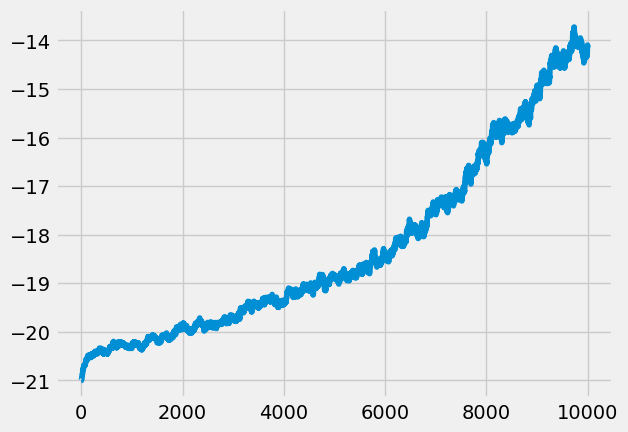

In [21]:
%matplotlib inline

style.use('fivethirtyeight')
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
xs = []
ys = []

def plot_graph2(data):
    for line in data:
        xs.append(float(line[0]))
        ys.append(float(line[1]))
        ax1.clear()
        
    ax1.plot(xs, ys)
    plt.pause(1)
    plt.show()

plot_graph2(hist_2)

In [22]:
#%time hist2 = train_model(env, model, total_episodes=12000)

In [23]:
#play_game(env, model)

In [24]:
#%time hist3 = train_model(env, model, total_episodes=1500)

In [25]:
#play_game(env, model)